# Combine all fasta into one big .hdf5 file
@author Harald Ringbauer, March 2020

In [3]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt
from itertools import groupby
from shutil import which
import os
import re as re
import h5py

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(f"Current machine: {socket_name}")
if socket_name == "DESKTOP-5RJD9NC":
    path = "/gitProjects/covid19_data"   # The Path on Harald's machine
if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/covid19_data/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
### Check whether required bins are available
req_bins = ["mafft"] 
for b in req_bins:
    s = which(b)
    if not s:
        print(f"Make sure to install {b} and have in path. I cannot find it!")
        
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

sys.path.append("./python3/")
from manipulate_fasta import fasta_iter_raw, fasta_iter

Current machine: compute-e-16-233.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/covid19_data


## Define Key Functions

In [17]:
def load_aligned_seq(fasta_path, align_id="Wuhan-Hu-1"):
    """Load Aligned Sequence fasta.
    Check against align_id and lgth.
    Return String"""
    if not os.path.exists(fasta_path):
        raise RuntimeWarning(f"Path does not exist: {fasta_path}")
    fiter = fasta_iter(fasta_path)
    iid_re, _ = next(fiter)
    
    if len(align_id)>0:
        if not (align_id in iid_re):
            raise RuntimeWarning(f"Reference ID {align_id} does not match {iid_re}")
    iid, seq = next(fiter)  # Get the Meat
    return iid, seq

def combine_fasta_alignments(paths, align_id="Wuhan-Hu-1"):
    """Load, and combine all the paths """
    n = len(paths)
    
    _, seq = load_aligned_seq(paths[0], align_id=align_id)
    k = len(seq)
    
    seqs = np.empty((n,k), dtype="|S1")  # Create place holder for all sequences
    iids = np.empty(n, dtype=object) # Place holder for the iids
    
    for i, path in enumerate(paths):
        iid, seq = load_aligned_seq(path, align_id=align_id)
        iids[i], seqs[i,:] = iid, list(seq) # Typecast into list so assignment works
    return iids, seqs

#######################################
#######################################

def post_process_counts(ct, drop=[b"n", b"-"]):
    """Post-process Pandas value Counts.
    drop: What allele to drop and not to count"""
    ct = ct.drop(labels = drop, errors="ignore")
    if len(ct)==1:
        gt_ct = [ct.values[0], 0]
        alleles = [ct.index[0], ""]
    else:
        gt_ct = [ct.values[0], ct.values[1]]
        alleles = [ct.index[0], ct.index[1]]
    return gt_ct, alleles

def produce_allele_stats(seq, drop=[b"n", b"-"], loci=[],
                         decode=True):
    """Produce allele counts for major/minor allele
    loci: Which Loci to analyze
    decode: Whether to decode S1 strings in output"""
    counts = []
    
    if len(loci)==0:
        k = np.shape(seqs)[1]
        loci = range(0,k)
        print(f"Running all Loci: n={len(loci)}")
        
    ref_count, alt_count = np.zeros(len(loci), dtype="int"), np.zeros(len(loci), dtype="int")
    ref, alt  =  np.empty(len(loci), dtype="|S1"), np.empty(len(loci), dtype="|S1")
    
    for i,l in enumerate(loci):
        ct = pd.value_counts(seqs[:,l])
        gts_c, alleles = post_process_counts(ct, drop=drop)
        ref_count[i], alt_count[i] = gts_c
        ref[i], alt[i] = alleles
    
    df = pd.DataFrame({"refcount":ref_count, "altcount":alt_count, 
                  "ref":ref, "alt":alt, "pos":loci})
    if decode:
        df['ref'] = df['ref'].str.decode("utf-8")
        df['alt'] = df['alt'].str.decode("utf-8")
    return df

####################################################
####################################################
### Manipulate Sequences and extract Info

def extract_idcs(seqs, pos, der="g"):
    """Extract idcs where seqs is allele 
    der on position pos. Return list of idcs"""
    idcs = seqs[:,pos] == der
    return idcs

def give_idx_deletion(seqs, deletion, del_str=b'n', mis_frac=0.75):
    """Return iid of Deletion"""
    seqs_del = seqs[:,deletion] # Extract the Sequences where there is a deletion
    idx = seqs_del == del_str
    print(f"Average Rate of n: {np.mean(idx):.4f}")
    sum_n = np.sum(idx, axis=1)
    iid_idx = sum_n > (len(deletion) * mis_frac)
    print(f"Found: {np.sum(iid_idx)} / {len(iid_idx)} Individuals")
    return  iid_idx, sum_n

#######################################################

def extract_var_df(df, min_count=1500, maf=0.05):
    """Extract and return Dataframe with MAF > maf"""
    tot_count = df1["altcount"] + df1["refcount"]
    idx = (df1["altcount"] / tot_count > 0.05) &  (tot_count>min_count)

    print(f"Found {np.sum(idx)} Variants with MAF>{maf}")
    df_var = df1[idx].copy()

    df_var["totcount"] = df_var["refcount"] + df_var["altcount"]
    df_var["maf"] = df_var["altcount"]/df_var["totcount"]
    return df_var

########################################################
########################################################

def save_h5(seqs, iids, path, output=True):
        """Create a new HDF5 File with Sequence Data.
        Each sequence entry is saved as a single char.
        seqs: Genomic Data: [k,l] array
        iids: IIDs to save into HDF5.
        path: Where to save the HDF5 to"""
        k, l = np.shape(seqs)  # Nr of Individuals and Nr of Loci
        assert(k == len(iids)) ## Sanity Chec
        
        max_len = np.max([len(iid) for iid in iids]) # Longest iid

        if os.path.exists(path):  # Do a Deletion of existing File there
            os.remove(path)
            
        dt = h5py.special_dtype(vlen=str)  # To have no problem with saving

        with h5py.File(path, 'w') as f0:
            ### Create all the Groups
            f_gt = f0.create_dataset("gt", (k,l), dtype='|S1')
            f_samples = f0.create_dataset("samples", (k,), dtype=dt)

            ### Save the Data
            f_gt[:] = seqs.astype("|S1")
            f_samples[:] = np.array(iids)   #.astype("S" + max_len)

        if output == True:
            print(f"Successfully saved {k} individuals to: {path}")

# Run and Combine

In [15]:
%%time
aligned_path_fasta = "./output/single_seq_aligned2.tsv"

df = pd.read_csv(aligned_path_fasta, sep="\t")
df = df[df["include"]==True].copy()
print(f"Will load {len(df)} Sequences from {aligned_path_fasta}")
### Manually filling in (next iteration has it automatic)
#df["aligned_path"] = "./output/singleseq_aligned/" + df["iid_clean"] + ".fasta"
###df.to_csv(aligned_path_fasta, sep="\t", index=False)

Will load 4954 Sequences from ./output/single_seq_aligned2.tsv
CPU times: user 33.3 ms, sys: 4.02 ms, total: 37.3 ms
Wall time: 36.2 ms


In [18]:
%%time
paths = df["aligned_path"][:]
iids, seqs = combine_fasta_alignments(paths, align_id="Wuhan-Hu-1")

CPU times: user 10.3 s, sys: 357 ms, total: 10.7 s
Wall time: 13.6 s


# Create HDF5 of Covid-19 sequences, with iids!

### Translate IIDs to original IIDs

In [19]:
%%time
save_h5(seqs, iids, path="./output/h5/covid_seqs.h5")

Successfully saved 4954 individuals to: ./output/h5/covid_seqs.h5
CPU times: user 62.7 ms, sys: 311 ms, total: 374 ms
Wall time: 12.9 s


# Run and Save Allelic Frequency Spectrum (SNPs)

In [20]:
%%time
df1 = produce_allele_stats(seqs, loci=[], drop=[b"-", b"n"])

Running all Loci: n=29903
CPU times: user 56.4 s, sys: 414 ms, total: 56.8 s
Wall time: 56.2 s


In [21]:
savepath = "./output/tables/allele_spectrum.tsv"
df1.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(df1)} Loci Statistics to {savepath}")

Saved 29903 Loci Statistics to ./output/tables/allele_spectrum.tsv


In [22]:
#savepath="./figures/share/sprotein.png"
def plot_ref_alt(df1, savepath="", xlim=[], leg_loc="center left",
                title=""):
    """Plot Reference and Alt Count along the genome"""
    plt.figure(figsize=(8,4))
    ax=plt.gca()
    ax.plot(df1["refcount"], "o", label="Ref Allele Count", ms=4)
    ax.plot(df1["altcount"], "o", label="Alt Allele Count", ms=4)
    ax.set_xlabel("Reference Position [Wuhan-Hu-1]")
    ax.set_ylabel("Count")
    ax.legend(loc=leg_loc)
    if len(xlim)>0:
        ax.set_xlim(xlim)
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}")
    if len(title)>0:
        ax.set_title(title)
    plt.show()

Saved to ./figures/dumpster/zoom_in_s.png


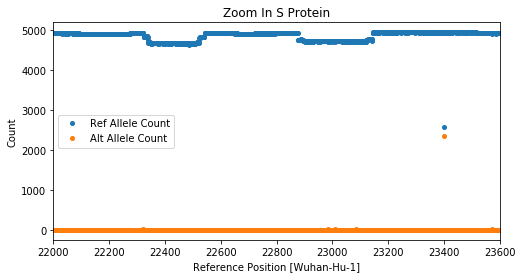

In [23]:
#plot_ref_alt(df1, xlim=[21400,25400], title="Zoom In S Protein",
#             savepath = "./figures/dumpster/zoom_in_s.png")
plot_ref_alt(df1, xlim=[22000,23600], title="Zoom In S Protein",
             savepath = "./figures/dumpster/zoom_in_s.png")
#plot_ref_alt(df1, xlim=[22600,23200], title="Zoom In S Protein Deletion?")

# Get idx of Deletions./figures/

In [77]:
iid_idx, sum_n =give_idx_deletion(seqs, deletion = np.arange(22900,23101))  # Big deletion in S
iid_idx, sum_n =give_idx_deletion(seqs, deletion = np.arange(22400,22500))  # Small deletion in S

Average Rate of n: 0.0660
Found: 109 / 1746 Individuals
Average Rate of n: 0.0309
Found: 47 / 1746 Individuals


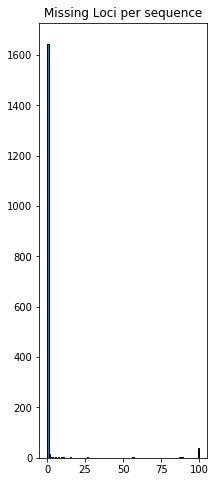

In [78]:
plt.figure(figsize=(3,8))
ax=plt.gca()
ax.hist(sum_n, bins=100, ec="k")
ax.set_title("Missing Loci per sequence")
plt.show()

In [79]:
df = pd.read_csv(aligned_path_fasta, sep="\t")
df = df[df["include"]==True].copy()
print(f"Loaded {len(df)} Sequences from {aligned_path_fasta}")

### Manually filling in (next iteration has it automatic)
df["aligned_path"] = "./output/singleseq_aligned/" + df["iid_clean"] + ".fasta"

Loaded 1746 Sequences from ./output/single_seq_aligned.tsv


# Create the Variants Table 
Run analyze_sequences to create MAF Table

In [24]:
savepath = "./output/tables/allele_spectrum.tsv"
df1 = pd.read_csv(savepath, sep="\t")
print(f"Loaded {len(df1)} Loci Statistics from {savepath}")
mx_ref = np.max(df1["refcount"])
print(f"Max Ref Count: {mx_ref}")

Loaded 29903 Loci Statistics from ./output/tables/allele_spectrum.tsv
Max Ref Count: 4953


In [25]:
### Showcase what variants we have
var_path = "./output/tables/variant_maf.tsv"
df_var = pd.read_csv(var_path, sep="\t")
df_var = extract_var_df(df1, min_count = 1500, maf = 0.05)

### Which Mutations
mutations = df_var["ref"] + ">" + df_var["alt"]
mutations.value_counts()

Found 17 Variants with MAF>0.05


c>t    5
t>c    4
g>a    3
g>t    3
g>c    1
a>g    1
dtype: int64

In [26]:
df_var

,refcount,altcount,ref,alt,pos,totcount,maf
240,2548,2251,t,c,240,4799,0.469056
1058,4222,669,c,t,1058,4891,0.136782
3036,2574,2346,t,c,3036,4920,0.476829
8781,4025,895,c,t,8781,4920,0.181911
11082,4223,687,g,t,11082,4910,0.139919
14407,2557,2378,t,c,14407,4935,0.481864
14804,4443,493,c,t,14804,4936,0.099878
17746,4382,553,c,t,17746,4935,0.112057
17857,4372,569,a,g,17857,4941,0.115159
18059,4346,588,c,t,18059,4934,0.119173


### Process Individuals with derived common alleles

In [27]:
def create_der_df(df, df_var, seqs):
    """Modify Dataframe df to contain
    derived Variant columns from df_var, 
    according to seqs"""
    df_der = df.copy()  # Copy from original dataframe
    
    for index, row in df_var.iterrows():
        idcs = extract_idcs(seqs, pos=row["pos"], der=row["alt"].encode())
        assert(np.sum(idcs) == row["altcount"])  # Sanity Check
        df_der[str(row["pos"])] = idcs 
    return df_der
#idcs = extract_idcs(seqs, pos=23402, der=b"g")

In [29]:
df_der = create_der_df(df, df_var, seqs)

In [30]:
### And now save it
savepath = "./output/tables/derived_common_snps.tsv"
df_der.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(df_der)} Individuals with derived Data to {savepath}")

Saved 4954 Individuals with derived Data to ./output/tables/derived_common_snps.tsv


# Area 51

### Load single aligned H5 sequence

In [33]:
path = "./output/h5/covid_seqs.h5"
f = h5py.File(path, "r") # Load for Sanity Check. See below!  
print("Loaded HDF5")
print(list(f))
print(np.shape(f["gt"]))
#assert(np.shape(f["gt"])[0]==len(f["samples"]))

Loaded HDF5
['gt', 'samples']
(4954, 29903)


In [122]:
%%time
iids1 = f["gt"][10,:]

CPU times: user 904 µs, sys: 1 ms, total: 1.91 ms
Wall time: 1.92 ms


In [114]:
df_meta = pd.read_csv("./data/apr20/metadata.tsv", sep="\t")

In [116]:
samples

array(['hCoV-19/USA/WA-S88/2020|EPI_ISL_417141|2020-03-01',
       'hCoV-19/USA/WA-S89/2020|EPI_ISL_417142|2020-02-29',
       'hCoV-19/USA/WA-S87/2020|EPI_ISL_417140|2020-03-01', ...,
       'hCoV-19/USA/WA-UW41/2020|EPI_ISL_415606|2020-03-08',
       'hCoV-19/USA/WA-UW44/2020|EPI_ISL_415609|2020-03-08',
       'hCoV-19/USA/WA-UW43/2020|EPI_ISL_415608|2020-03-08'], dtype=object)

In [87]:
samples = f["samples"][:]

In [90]:
epi = df_meta["gisaid_epi_isl"] 

In [94]:
epi2 = [s.split("|")[1] for s in samples]

In [98]:
len(set(epi2+list(epi)))

3343

In [99]:
len(f["samples"])

3325

In [111]:
len(df_meta)

3323

In [109]:
idx = df_meta["strain"].str.contains('|'.join(samples))

In [110]:
np.sum(idx)

3322

In [112]:
df_meta[~idx]

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,location,country_exposure,...,length,host,age,sex,originating_lab,submitting_lab,authors,url,title,date_submitted
3312,bat/Yunnan/RaTG13/2013,ncov,EPI_ISL_402131,?,2013-07-24,Asia,China,Yunnan,Pu'er,China,...,29855,Rhinolophus affinis,?,Male,"Wuhan Institute of Virology, Chinese Academy o...","Wuhan Institute of Virology, Chinese Academy o...",Zhu et al,https://www.gisaid.org,?,2020-01-24


In [113]:
[s for s in samples if "bat" in s]

['hCoV-19/bat/Yunnan/RaTG13/2013|EPI_ISL_402131|2013-07-24']

In [119]:
df_meta["host"].value_counts()

Human                  3299
Manis javanica            9
human                     9
Environment               4
Canine                    1
Rhinolophus affinis       1
Name: host, dtype: int64